# LogisticRegression on **Diamonds** dataset, using a classifier on a regression dataset

## Introduction

- In this project I apply the **LogisticRegression** classifier on the **Diamonds** dataset from **OpenML**.
- The main reason for using **LogisticRegression** on this dataset is documenting one of the ways to transform a regression dataset to a classification dataset.
- The **Challenge** I am taking on is handling and observing how the accuracy and predictions change compared to the other project, where I used **LinearRegression**.

In [59]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Loading the Dataset and transforming it into a Classification Task

The dataset **Diamonds** is from [OpenML](https://www.openml.org/d/44979).
After loading and inspecting the data, I transform the **continuous target (price)** into categorical labels by dividing it into 4 bins: 

**• 0 - 5000**

**• 5000 - 10000**

**• 10000 - 15000**

**• 15000 - MAX**

The binning process converts the regression problem into a **Clasification Task**.
With ≈54000 instances, 4 bins is enough, as the first bin is by far the most **dense**  

In [65]:
data = fetch_openml('diamonds', as_frame=True)

X = data.data
y = data.target

X

bins = [0, 5000, 10000, 15000, y.max()]
labels = [0, 1, 2, 3]
y = pd.cut(y, bins=bins, labels=labels)

X, X.isna().sum(), y

(       carat        cut color clarity  depth  table     x     y     z
 0       0.23      Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43
 1       0.21    Premium     E     SI1   59.8   61.0  3.89  3.84  2.31
 2       0.23       Good     E     VS1   56.9   65.0  4.05  4.07  2.31
 3       0.29    Premium     I     VS2   62.4   58.0  4.20  4.23  2.63
 4       0.31       Good     J     SI2   63.3   58.0  4.34  4.35  2.75
 ...      ...        ...   ...     ...    ...    ...   ...   ...   ...
 53935   0.72      Ideal     D     SI1   60.8   57.0  5.75  5.76  3.50
 53936   0.72       Good     D     SI1   63.1   55.0  5.69  5.75  3.61
 53937   0.70  Very Good     D     SI1   62.8   60.0  5.66  5.68  3.56
 53938   0.86    Premium     H     SI2   61.0   58.0  6.15  6.12  3.74
 53939   0.75      Ideal     D     SI2   62.2   55.0  5.83  5.87  3.64
 
 [53940 rows x 9 columns],
 carat      0
 cut        0
 color      0
 clarity    0
 depth      0
 table      0
 x          0
 y          0
 z     

## Studying the Categorical Columns

After finding out what types of values are present, I list all the unqiue values in the **categorical columns** for encoding purposes.
**Nothing changes here.**

In [61]:
list(X['cut'].unique()), list(X['color'].unique()), list(X['clarity'].unique())

(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'],
 ['E', 'I', 'J', 'H', 'F', 'G', 'D'],
 ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'])

## Creating Maps for encoding Categorical Values + Feature Engineering

In this step, I create a map for each non-numerical **column** to encode its values in numeric form. This allows the model to interpret and use these features effectively during training.

In contrast to **LinearRegression**, even though both models are linear and try to predict what **'weights'** to use, for **LogisticRegression** I don't need to eliminate columns or create new ones to avoid collinearity thanks to regularization(with **L2**), the model penalized **'big'** coeficients.

**A little context/story: These linear models try to assign a weight to each feature. When features are highly correlated (multicollinearity), the model struggles to decide which feature should get the credit, leading to unstable coeficients.**
**Regularization in LogisticRegression addresses this issue.**

In [62]:
cut_map = {'Fair' : 0, 'Good' : 1, 'Very Good' : 2, 'Premium' : 3, 'Ideal' : 4}
color_map = {'D' : 6, 'E' : 5, 'F' : 4, 'G' : 3, 'H' : 2, 'I' : 1, 'J' : 0}
clarity_map = {'I1' : 0, 'SI2' : 1, 'SI1' : 2, 'VS2' : 3, 'VS1' : 4, 'VVS2' : 5, 'VVS1' : 6, 'IF' : 7}

X['cut'] = X['cut'].map(cut_map)
X['color'] = X['color'].map(color_map)
X['clarity'] = X['clarity'].map(clarity_map)
X['volume'] = round(X['x'] * X['y'] * X['z'], 1)
X.drop(columns=['x', 'y', 'z'], inplace=True)
X


,carat,cut,color,clarity,depth,table,volume
0,0.23,4,5,1,61.5,55.0,38.2
1,0.21,3,5,2,59.8,61.0,34.5
2,0.23,1,5,4,56.9,65.0,38.1
3,0.29,3,1,3,62.4,58.0,46.7
4,0.31,1,0,1,63.3,58.0,51.9
...,...,...,...,...,...,...,...
53935,0.72,4,6,2,60.8,57.0,115.9
53936,0.72,1,6,2,63.1,55.0,118.1
53937,0.70,2,6,2,62.8,60.0,114.4
53938,0.86,3,2,1,61.0,58.0,140.8


## Splitting the Data

Again, I split the data with a **train_test_split**, and plotted two graphs below showing a really even split in classes between **y_train** and **y_test**.

In this case, I don't need to log-scale the data, **LogisticRegression** is not sensitive to a sparse dataset. It works with scalars rather than distance, it ignores '0' features and **regularization** helps it assign the corect weights.

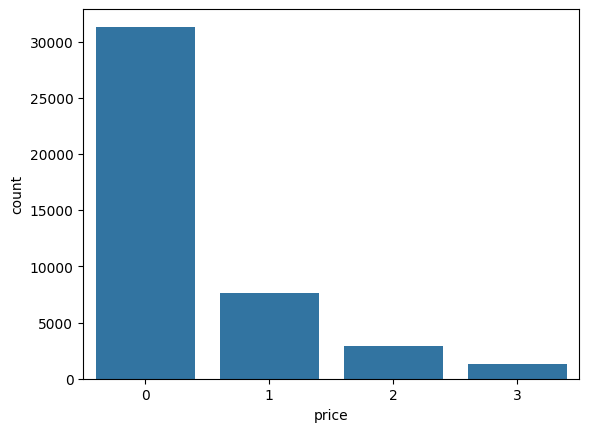

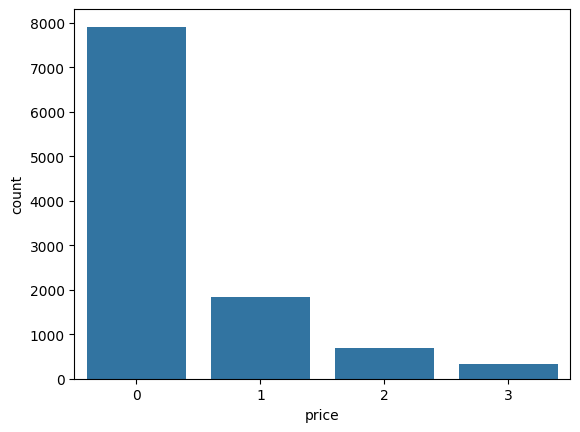

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sns.countplot(x=y_train)
plt.show()
sns.countplot(x=y_test)
plt.show()

## Training + Pipeline + Discussion about **Scaling**

I used a pipeline for code cleanliness and scalability sake, used a grid to find the best **'C'** hyperparameter (**'C'** controls how much coeficients are being penalized, '0.01' - strong; '100' - weak) and, for clarity, I fixed the other hyperparameters as standard values.

After using **GridSearch**, the best **'C'** value was **'10'** indicating a weak penalization.
Meaning values of big magnitude, if any, are important and are allowed to fully contribute to the model.

**Scaling** was needed. Even though it is a linear model and does not use **'distances'**, I used **StandardScaler** to help **Regularization**.  If I hadn't scale the data, the regularizator would have penalized big values wrongly, affecting regularization between features.

In [64]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

params = {
    "model__C" : [0.01, 0.1, 1, 10, 100],
    "model__penalty" : ['l2'],
    "model__solver" : ['lbfgs'],
    "model__multi_class" : ['multinomial']
}

grid = GridSearchCV(pipeline, params, cv = 5, scoring='accuracy')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred, labels=None), grid.best_score_

(array([[7705,  206,    0,    0],
        [ 224, 1525,   90,    5],
        [   1,  115,  492,   86],
        [   0,    0,  135,  204]]),
 np.float64(0.922297995328757))

## Conclusion

There is a very big difference in behaviour between the two models.
Again, coming to the same conclusion, understanding the **core principles** of the model you are working with is among the most important factors.

After the **GridSearch**, the models best score was ≈0.92, a little lower than the other model.
After using a **ConfusionMatrix**, it could be clearly seen that the predictions where very close to the real values, the main problem was a small difference in predicted values vs the real ones (in most cases <200) that **Classified** the instance in a neighbouring class (e.g., real price:4950, prediction:5100), in this case, even though the values were very close, the prediction was counted as wrong.